In [1]:
import numpy as np
import pandas as pd
import pickle
from Bio import SeqIO
from Bio.Seq import Seq
from Bio.SeqRecord import SeqRecord
import os 
from functions import *
from matplotlib import pyplot as plt
import seaborn as sns

# Load dataset

In [2]:
S = pd.read_csv('../data/IMdata/S.csv')
S = pd.read_csv('../data/IMdata/S.csv',index_col=0)
A = pd.read_csv('../data/IMdata/A.csv',index_col=0)
log_rpkm_norm = pd.read_csv('../data/IMdata/log_rpkm_norm.csv', index_col=0)
regulons = load_pickle('../data/IMdata/lpwcfs1_regulons.pkl')
IM_list = list(S.columns)
sample_list = list(A.columns)

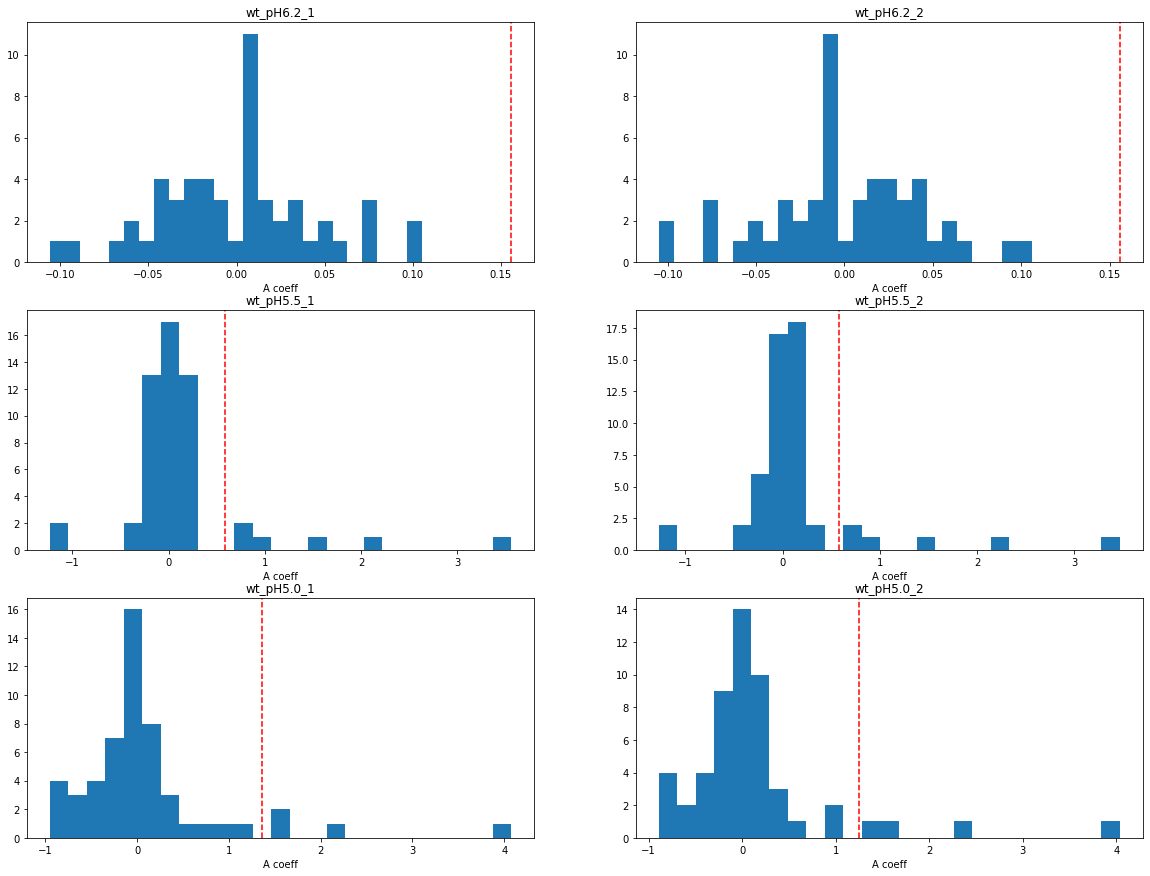

In [3]:
fig, axs = plt.subplots(3,2,figsize=(20,15))
for i in range(6):
    x,y = int(i/2), int(i%2)
    title_name = sample_list[i]
    thres = compute_threshold( A , title_name ,cutoff=10)
    axs[x][y].hist(A[title_name], bins=25);
    axs[x][y].axvline(x=thres, color='r', linestyle='--')
    axs[x][y].set_title(title_name)
    axs[x][y].set_xlabel('A coeff')

Text(15.0, 0.5, 'I-modulon')

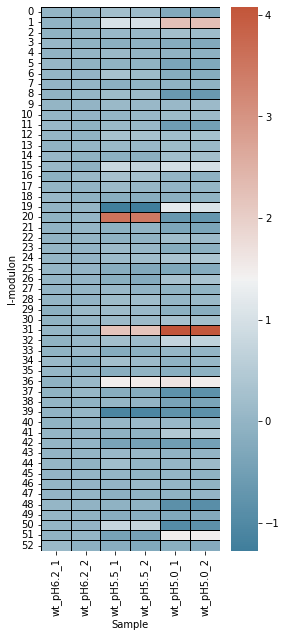

In [5]:
fig, ax = plt.subplots(1,1, figsize=(4,10))
sns.heatmap( A[A.columns[0:6]], yticklabels=True, 
            linecolor='black',linewidths=1,
            cmap= sns.diverging_palette(230, 20, as_cmap=True), ax = ax)
ax.set_xlabel('Sample')
ax.set_ylabel('I-modulon')